In [1]:
!pip install easyocr

In [2]:
!pip install imutils

In [3]:
!pip install pymysql

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


클래스 번호:  0 
클래스: norm 
norm일 확률:  0.9677497148513794

차량번호 앞자리:  101하 
차량번호 뒷자리:  4609


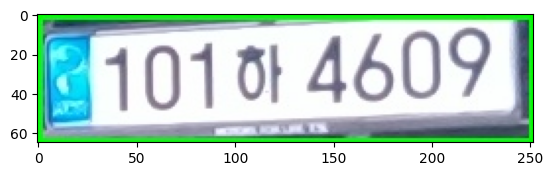

In [42]:
import cv2
from PIL import Image
import imutils
#from google.colab.patches import cv2_imshow
from imutils.perspective import four_point_transform
import matplotlib.pyplot as plt
import re
import numpy as np
import easyocr
 
webcam = cv2.VideoCapture(0)

#-- 웹캠 오류 처리 
if not webcam.isOpened():
    print("WebCam is not running")
    exit()
     
time_num= 0    
image_num = 0
    
#-- 웹캠 열기
while webcam.isOpened():
         
    status, frame = webcam.read()
    time_num = time_num + 1
    
    if not status:
        break
 
    #-- 출력창
    #cv2.imshow("WebCam", frame)
    
    #-- 캡쳐 프레임 간격 설정
    if time_num == 1:
        image_num = image_num + 1
        cv2.imwrite('img'+str(image_num)+'.png', frame) #-- 본인 편의에 맞게 경로 설정 및 이미지 이름 변경
        time_num = 0
        if image_num == 1:
            break
    
webcam.release()
# cv2.destroyAllWindows()

img_path = 'img1.png'

img = cv2.imread(img_path)

with open('obj.names', 'r') as f:
    classes = f.read().splitlines()

#cfg 파일에 batch, subdivisions 는 둘 다 1이어야함

net = cv2.dnn.readNetFromDarknet('yolov4-tiny-custom.cfg', 'yolov4-tiny-custom_best.weights')

model = cv2.dnn_DetectionModel(net)
model.setInputParams(scale=1 / 255, size=(416, 416), swapRB=True)

classIds, scores, boxes = model.detect(img, confThreshold=0.6, nmsThreshold=0.4)

clss = classIds.tolist()
score = scores.tolist()

# 주차딱지 변수 값 지정
# Object Detection 했을 때 주차딱지가 Detection 안 되면 class_num_y와 class_name_yellow 는 'x'값을 가짐
# 주차딱지가 Detection 되면 class_num_y는 '3', class_name_yellow 는 '주차딱지' 값을 가짐 (아래에 있는 if 문)

class_num_y = 'x'
class_name_yellow = 'x'

reader = easyocr.Reader(['ko'])

# # 검출된 bbox 중, 클래스가 0(norm), 1(elec), 3(yellow) 이면 이미지 출력

for i in range(len(clss)):
    box = boxes[i].tolist()
    w = box[0]
    h = box[1]
    x = box[2]
    y = box[3]
    bbox = img[h:y+h, w:x+w]



    if clss[i] == 0:
        print('클래스 번호: ', clss[i], '\n클래스: norm', '\nnorm일 확률: ', score[i])

        # 22.11.05  옮김 ㅎㅅㅇ
        class_num = str(clss[i])
        class_name = '일반'
        

        cv2.rectangle(bbox, (0,0), (x, y), (0,255,0), 3)
        #cv2.imshow(bbox)
        cv2.imwrite('norm.jpg', bbox) #저장

        #22.11.05 추가 ㅎㅅㅇ
        norm = Image.open('norm.jpg')

        if bbox is None:
            print('Image load failed!')
            bbox.exit()

        src_hsv = cv2.cvtColor(bbox, cv2.COLOR_BGR2HSV)

				# 설정한 검은색의 rgb 범위 (0, 0, 0) ~ (80, 80, 80)
        dst1 = cv2.inRange(bbox, (0, 0, 0), (80, 80, 80))
        cv2.imwrite('norm_black.jpg', dst1)

        norm_black = Image.open('norm_black.jpg')

				# 가로 세로 길이 조절
        norm_black = norm_black.resize((int(norm_black.width), int(norm_black.height)))
        norm_black.save('norm_black.jpg')
        norm_black = Image.open('norm_black.jpg')

				# ------------ OCR
        result = reader.readtext(norm_black)

				#result에서 00가0000 형태인지 찾기
                # 22.11.05 수정 ㅎㅅㅇ
        for a in result:
          if re.match('[0-9]{2,3}[가-힣]{1}[0-9]{4}',a[1].replace(' ','')):
            pass
          elif not re.match('[0-9]{2,3}[가-힣]{1}[0-9]{4}',a[1].replace(' ','')):
            norm_re = norm_black.resize((int(norm_black.width*2), int(norm_black.height)))         
            plt.figure()
            plt.imshow(norm_re)
            norm_re.save('norm_re.jpg',)
            norm_re=Image.open('norm_re.jpg')
            result = reader.readtext(norm_re)

        # 22.11.05 추가  ㅎㅅㅇ      
        if 0<=len(result)<= 6:
            norm_norm = Image.open("norm.jpg")
            plt.imshow(norm_norm)
            result = reader.readtext(norm_norm)


    elif clss[i] == 1:
        print('클래스 번호: ', clss[i], '\n클래스: elec', '\nelec일 확률: ', score[i])

        #22.11.05 옮김 ㅎㅅㅇ
        class_num = str(clss[i])
        class_name = '전기'

        cv2.rectangle(bbox, (0,0), (x, y), (0,255,0), 3)
        #cv2.imshow(bbox)
        cv2.imwrite('elec.jpg', bbox)

        #22.11.05 추가 ㅎㅅㅇ
        elec = Image.open('elec.jpg')

        if bbox is None:
            print('Image load failed!')
            bbox.exit()

        src_hsv = cv2.cvtColor(bbox, cv2.COLOR_BGR2HSV)

        dst1 = cv2.inRange(bbox, (0, 0, 0), (70, 80, 80))
        cv2.imwrite('elec_black.jpg', dst1)
        elec_black = Image.open('elec_black.jpg')

				# 가로 세로 길이 조절
        elec_black = elec_black.resize((int(elec_black.width), int(elec_black.height)))
        elec_black.save('elec_black.jpg')
        elec_black = Image.open('elec_black.jpg')
        

				# ------------ OCR
        result = reader.readtext(elec_black)

            # result에서 00가0000 형태인지 찾기
            #22.11.05 수정 ㅎㅅㅇ
        for a in result:
          if re.match(r'[0-9]{2,3}[가-힣]{1}[0-9]{4}',a[1].replace(' ','')):
              pass
          elif not re.match('[0-9]{2,3}[가-힣]{1}[0-9]{4}',a[1].replace(' ','')):
            elec_re = elec_black.resize((int(elec_black.width*2), int(elec_black.height)))
            plt.figure()
            elec_re.save('elec_re.jpg',)
            elec_re=Image.open('elec_re.jpg')
            result = reader.readtext(elec_re)

        #22.11.05 추가 ㅎㅅㅇ
        if 0<=len(result)<= 6:
            elec_norm = Image.open("elec.jpg")
            plt.imshow(elec_norm)
            result = reader.readtext(elec_norm)

    if clss[i] == 3:
        print('클래스 번호: ', clss[i], '\n클래스: yellow', '\nyellow일 확률: ', score[i])
        cv2.rectangle(bbox, (0,0), (x, y), (0,255,0), 3)
        #cv2.imshow(bbox)
        class_num_y = str(clss[i])
        class_name_yellow = '주차딱지'


# -------------------한글 & 숫자 추출함수-------------------
def result_plate():
  result_list = []

  # 번호판으로 올 수 있는 문자만 추출 하기 위함.
  plate = ['가', '나', '다', '라', '마', '거', '너', '더', '러', '머', '버', '서', '어', '저', '고', '노', '도', '로', '모', '보', '소', '오', '조', '구', '누', '두', '루', '무', '부', '수', '우', '주', '허', '하', '호', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
  first_num = ''
  second_num = ''
  str_cnt = 0 # 앞 번호판의 문자 (1글자)만 읽기 위함.

  for i in result :
    for j in i[1] :
      for str in plate :
          if j == str :
            result_list.append(j)
            
      # 문자를 기준으로 앞번호 , 뒷 번호를 슬라이싱.
      if '가'<=j<='힣' and str_cnt == 0 : 
        str_cnt += 1
        first_num=result_list[:result_list.index(j)+1]
        second_num=result_list[result_list.index(j)+1:] 
        
        # 형식에 맞게 들어왔는지 체크.
        if 3<=len(first_num)<=4 :
          first_num = ''.join(first_num)
        else :
          first_num = 'error'

      # 앞 번호 문자 추출이후 뒷 번호를 한번 더 체크
      # 번호판 앞 번호와 뒷 번호가 분리되지 않고 result로 들어온 경우. ex) '101하 4609'
      # 번호판 앞 번호와 뒷 번호가 분리되어 result로 들어온 경우. ex)'101하' , '4609'
      # 번호판 뒷 번호에 필요없는 문자가 섞여있는 경우 ex)'107rㄱㄱ1 6540가00' 모두 걸러냄.
      
      else :
          result_list2 = [n for n in result_list if '0'<=n<='9' not  in result_list]
          if len(result_list2)== 0 :
            result_list2 = [n for n in result_list if '0'<=n<='9' in result_list]
          second_num = ''.join(result_list2[-4:])

  return first_num,second_num
first_num , second_num = result_plate()


print(#'클래스 번호:', class_num,
      # '\n클래스 이름: ', class_name,
      '\n차량번호 앞자리: ', first_num,
      '\n차량번호 뒷자리: ', second_num)

In [30]:
#임의로 시간 설정함
from datetime import datetime

now = datetime.now()

in_time = str(now.hour) + ":"+ str(now.minute)

out_time = str(now.hour) + ":" + str(now.minute)

In [43]:
####### 입차 시 사용하는 Table : db_test

import pymysql

conn = pymysql.connect(host='127.0.0.1', user='root', password='multi123', db = 'db_test', charset='utf8')

cur = conn.cursor()

#아랫줄은 제일 처음에 table 생성 시에만 사용함
#cur.execute("create table userTable (last_num char(4), car_type char(1), car_yello char(1), first_num char(4), intro_time varchar(20), outro_time varchar(20))")

cur.execute(f"insert into userTable values(\"{second_num}\", \"{class_num}\", \"{class_num_y}\", \"{first_num}\", \"{in_time}\", \"{out_time}\")")

conn.commit()

1

In [46]:
###### 출차 시 사용하는 Table : db_test_out
## 출차 때 사용할 Table은 필요 없을지도...?

import pymysql

conn = pymysql.connect(host='127.0.0.1', user='root', password='multi123', db = 'db_test_out', charset='utf8')

cur = conn.cursor()

#아랫줄은 제일 처음에 table 생성 시에만 사용함
cur.execute("create table userTable (last_num char(4), first_num char(4))")

cur.execute(f"insert into userTable values(\"{second_num}\", \"{first_num}\")")

conn.commit()

1

In [47]:
conn.commit()

In [55]:
# import pymysql

conn = pymysql.connect(host='127.0.0.1', user='root', password='multi123', db = 'db_test', charset='utf8')
    
# Dict형식의 CURSOR  
cur = conn.cursor(pymysql.cursors.DictCursor)

# SQL 작성 
sql_in = "select * from usertable"

# SQL 실행
cur.execute(query=sql_in)

# 결과 가져오기
result_in = cur.fetchall()

result_in

[{'last_num': '2457',
  'car_type': '0',
  'car_yello': '3',
  'first_num': '',
  'intro_time': '15:15',
  'outro_time': '16:30'},
 {'last_num': '2457',
  'car_type': '0',
  'car_yello': '3',
  'first_num': '54오',
  'intro_time': '8:52',
  'outro_time': '8:52'},
 {'last_num': '6540',
  'car_type': '1',
  'car_yello': 'x',
  'first_num': '07호',
  'intro_time': '8:52',
  'outro_time': '8:52'},
 {'last_num': '4609',
  'car_type': '0',
  'car_yello': 'x',
  'first_num': '101하',
  'intro_time': '8:52',
  'outro_time': '8:52'}]

In [63]:
import pandas as pd

df_in = pd.DataFrame(result_in)
df_in

,last_num,car_type,car_yello,first_num,intro_time,outro_time
0,2457,0,3,,15:15,16:30
1,2457,0,3,54오,8:52,8:52
2,6540,1,x,07호,8:52,8:52
3,4609,0,x,101하,8:52,8:52


In [71]:
find = df_in[df_in['last_num'] == second_num]
find

,last_num,car_type,car_yello,first_num,intro_time,outro_time
3,4609,0,x,101하,8:52,8:52


In [95]:
find['intro_time'].values[0]

'8:52'

In [88]:
str(find['intro_time']).split("\n")[0].split('    ')[1].split(':')

'8:52'

In [90]:
find['car_type']

3    0
Name: car_type, dtype: object

# 출차 했을 때 신호 받고 webcam - yolo - ocr 실행하고 second_num(last_num) & first_num 변수 생성

In [138]:
import pandas as pd
import pymysql

conn = pymysql.connect(host='127.0.0.1', user='root', password='multi123', db = 'db_test', charset='utf8')
    
# Dict형식의 CURSOR  
cur = conn.cursor(pymysql.cursors.DictCursor)

# SQL 작성 
sql_in = "select * from usertable"

# SQL 실행
cur.execute(query=sql_in)

# 결과 가져오기
result_in = cur.fetchall()

df_in = pd.DataFrame(result_in)
find = df_in[df_in['last_num'] == second_num]

##출차시 사용할 함수

def calc_price():
    out = datetime.now()

    if out.minute > int(find['intro_time'].values[0].split(':')[1]):
        h = (out.hour - int(find['intro_time'].values[0].split(':')[0]))
        m = out.minute - int(find['intro_time'].values[0].split(':')[1])
    elif out.minute < int(find['intro_time'].values[0].split(':')[1]):
        h = (out.hour - int(find['intro_time'].values[0].split(':')[0])) - 1
        m = out.minute + (60 - int(find['intro_time'].values[0].split(':')[1]))

    if find['car_type'].values[0] == '0':
        if find['car_yello'].values[0] == 'x':
            price = h*60*100 + m*100
        elif find['car_yello'].values[0] == '3':
            price = 0
    elif find['car_type'].values[0] == '1':
        if find['car_yello'].values[0] == 'x':
            price = h*60*50 + m*50
        elif find['car_yello'].values[0] == '3':
            price = 0

    return price

In [139]:
calc_price()

11600

* 아두이노로 price 값 전달하려면 이 때 db 따로 있어야 할 듯